In [46]:
import os
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from img2vec_pytorch import Img2Vec
from PIL import Image
import pickle
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
import tkinter as tk
from tkinter import filedialog
from sklearn.model_selection import GridSearchCV
from skimage import feature
from sklearn.metrics import ConfusionMatrixDisplay

## Grain image classification

This notebook loads a dataset of images of four kinds of different grains represented in .png format, trains machine learning models for classification, and tests the models.

Choose the dataset:

In [47]:
dataset = "data/quantity"
# dataset = "data/quality"

Functions for loading and processing the images:

In [48]:
from PIL import Image, ImageFilter

img2vec = Img2Vec()

def load_image(file, i):
    if not file.lower().endswith(".png"):
        raise Exception("Invalid file name")
    print(f"Loading {file}")
    image = Image.open(file)
    features = img2vec.get_vec(image)
    label = i
    return features, label

def prepare_data(directory, data_file, labels_file):
    failed_files = []
    data = []
    labels = []

    # load the images and labels from the directory
    for i in range(4):
        path = os.path.join(directory, ["kaura", "ohra", "ruis", "vehna"][i])
        files = [os.path.join(path, file) for file in os.listdir(path)]
        for j, file in enumerate(files):
            try:
                img, label = load_image(file, i)
                data.append(img)
                labels.append(label)
                print(f"Loaded {file}")
            except:
                failed_files.append(file)
                continue

    if not failed_files:
        print("All files loaded successfully")
    else:
        print(f"Failed to load files {failed_files}")

    # save the data and labels as numpy arrays for classification
    data_np = np.array(data)
    labels_np = np.array(labels)
    print("Saving data...")
    np.save(data_file, data_np)
    np.save(labels_file, labels_np)
    print(f"Data saved successfully in {data_file} and {labels_file}")
    return data_np, labels_np

def load_cached(directory, data_file, labels_file):
    try:
        data, labels = np.load(data_file), np.load(labels_file)
        print('Successfully loaded cached data')
        return data, labels
    except:
        return prepare_data(directory, data_file, labels_file)

c:\Users\mirok\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mirok\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load the training data and split into training and validation sets:

In [49]:
def split_data():
    if dataset == "data/quality":
        x, y = load_cached(dataset + "/train", "training_data_quality.npy", "training_labels_quality.npy")
    else:
        x, y = load_cached(dataset + "/train", "training_data_quantity.npy", "training_labels_quantity.npy")
    x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.25, shuffle=True, stratify=y)
    return x_train, x_validation, y_train, y_validation

print("Splitting data...")
x_train, x_validation, y_train, y_validation = split_data()
print("Data split successfully")

Splitting data...
Successfully loaded cached data
Data split successfully


Train the models:

In [50]:
def train_models(x_train, y_train, x_validation, y_validation):

    print("Training random forest model...")
    random_forest_model = RandomForestClassifier()
    random_forest_model.fit(x_train, y_train)
    if dataset == "data/quality":
        pickle.dump(random_forest_model, open("random_forest_model_quality.sav", 'wb'))
        print("Random forest model trained successfully and saved in random_forest_model_quality.sav")
    else:
        pickle.dump(random_forest_model, open("random_forest_model_quantity.sav", 'wb'))
        print("Random forest model trained successfully and saved in random_forest_model_quantity.sav")

    print("Training kNN model...")
    knn_3_model = KNeighborsClassifier()
    knn_3_model.fit(x_train, y_train)
    if dataset == "data/quality":
        pickle.dump(knn_3_model, open("knn_3_model_quality.sav", 'wb'))
        print("kNN model trained successfully and saved in knn_3_model_quality.sav")
    else:
        pickle.dump(knn_3_model, open("knn_3_model_quantity.sav", 'wb'))
        print("kNN model trained successfully and saved in knn_3_model_quantity.sav")

    print("Training MLP model...")
    MLP_model = MLPClassifier()
    MLP_model.fit(x_train, y_train)
    if dataset == "data/quality":
        pickle.dump(MLP_model, open("MLP_model_quality.sav", 'wb'))
        print("MLP model trained successfully and saved in MLP_model_quality.sav")
    else:
        pickle.dump(MLP_model, open("MLP_model_quantity.sav", 'wb'))
        print("MLP model trained successfully and saved in MLP_model_quantity.sav")

train_models(x_train, y_train, x_validation, y_validation)

Training random forest model...
Random forest model trained successfully and saved in random_forest_model_quantity.sav
Training kNN model...
kNN model trained successfully and saved in knn_3_model_quantity.sav
Training MLP model...
MLP model trained successfully and saved in MLP_model_quantity.sav


Evaluate the models on the validation data:

Random Forest accuracy:  0.891
kNN accuracy:  0.891
MLP accuracy:  0.941


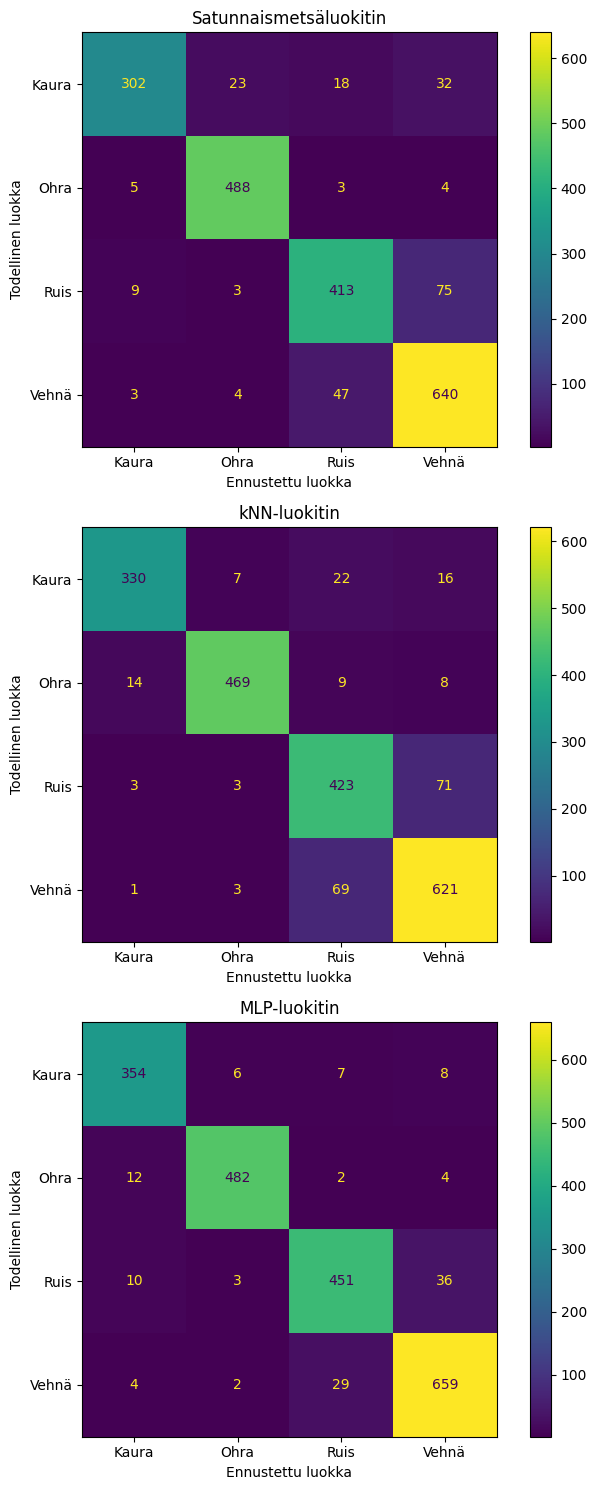

In [56]:
import matplotlib.pyplot as plt

def evaluate_models(x_validation, y_validation):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 15))

    models = ["random_forest_model", "knn_3_model", "MLP_model"]
    titles = ["Random Forest", "kNN", "MLP"]

    for i, model_name in enumerate(models):
        if dataset == "data/quality":
            model = pickle.load(open(f"{model_name}_quality.sav", 'rb'))
        else:
            model = pickle.load(open(f"{model_name}_quantity.sav", 'rb'))
        accuracy = model.score(x_validation, y_validation)
        print(f"{titles[i]} accuracy: ", round(accuracy, 3))

        y_pred = model.predict(x_validation)
        cm = confusion_matrix(y_validation, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kaura", "Ohra", "Ruis", "Vehnä"])
        disp.plot(ax=axs[i])
        if model_name == "random_forest_model":
            disp.im_.axes.set_title("Satunnaismetsäluokitin")
        else:
            axs[i].set_title(f"{titles[i]}-luokitin")
        axs[i].set_xlabel("Ennustettu luokka")
        axs[i].set_ylabel("Todellinen luokka")

    plt.tight_layout()
    plt.show()

evaluate_models(x_validation, y_validation)

Load the test data:

In [52]:
if dataset == "data/quality":
    x_test, y_test = load_cached(dataset + "/holdout", "holdout_data_quality.npy", "holdout_labels_quality.npy")
else:
    x_test, y_test = load_cached(dataset + "/holdout", "holdout_data_quantity.npy", "holdout_labels_quantity.npy")

Successfully loaded cached data


Evaluate the models on the test data:

Random Forest accuracy:  0.888
kNN accuracy:  0.905
MLP accuracy:  0.944


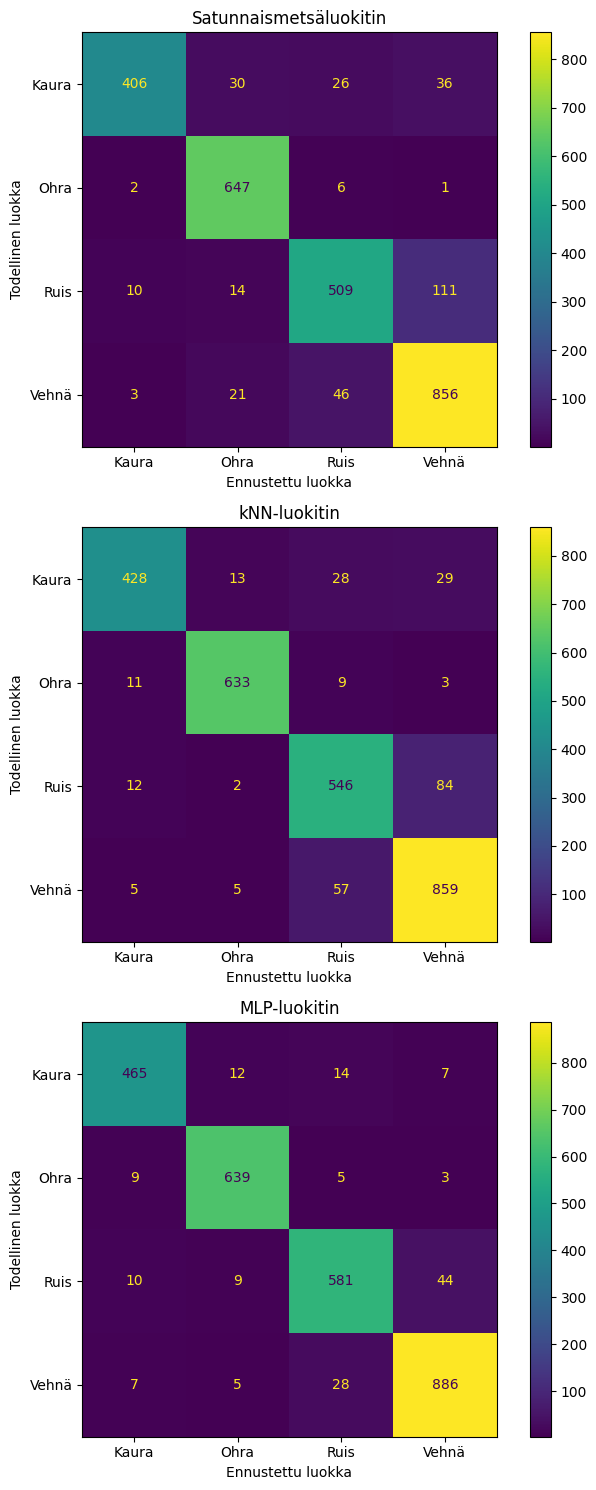

In [57]:
evaluate_models(x_test, y_test)

Test image files manually:

In [54]:
# model = pickle.load(open("MLP_model_quality.sav", 'rb'))
# while True:

#     try:
#         # open a file browser to select a file from your storage

#         root = tk.Tk()
#         root.withdraw()

#         file_path = filedialog.askopenfilename()

#         # read the image

#         img = load_image(file_path, 0)[0]

#         # predict the class

#         prediction = model.predict([img])

#         if prediction[0] == 0:
#             print("Prediction: kaura")
#         elif prediction[0] == 1:
#             print("Prediction: ohra")
#         elif prediction[0] == 2:
#             print("Prediction: ruis")
#         elif prediction[0] == 3:
#             print("Prediction: vehnä")

#     except:
#         print("File browser closed")
#         break
